# Timeseries of NASA SMAP soil moisture initiated at co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

In [61]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_PM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

#### Read and subset to Colorado Landslides >= year 2015

In [66]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
#                        'landslide', 'nasa.glc.export.csv')
                        'landslide', 'nasa_global_landslide_catalog_point.csv')

os.path.exists(glc_file)
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                            glc['admin_division_name'] == 'Colorado') & (
                            glc['landslide_trigger'] != 'freeze_thaw') & (
                            glc['landslide_trigger'] != 'snowfall_snowmelt') & (
                            glc['landslide_trigger'] != 'no_apparent_trigger') & (
                            glc['landslide_trigger'] != 'other') & (
                            glc['landslide_trigger'] != 'unknown')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-01-01']

print(glc_co_gt2015.shape)
print(np.unique(glc_co_gt2015['landslide_trigger']))
print(glc_co_gt2015.columns)

(39, 31)
['continuous_rain' 'downpour' 'rain']
Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')


#### Get all SMAP data files, sorted

In [6]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 'smap_l2')
smap_files = sorted(glob(os.path.join(data_dir, '*.h5')))
smap_files[0:5]


['/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150331_R17000_002.h5',
 '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150401_R17000_002.h5',
 '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150402_R17000_001.h5',
 '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150403_R17000_002.h5',
 '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150404_R17000_002.h5']

#### Peak inside a file to search which variables I need

In [7]:
file = '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20170414_R18290_001.h5'
os.path.exists(file)
#f = h5py.File(file, 'r')
#f.shape
sm_data, date = read_smap(file, 24)
sm_data.shape

(1624, 3856)

In [8]:
f = h5py.File(file, 'r')
print(file)

print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1
print('\n')

# Lets focus on the AM overpass for this example
group_id=list(f.keys())[1]; 

i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1
f.close()

/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20170414_R18290_001.h5
Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM
3	Soil_Moisture_Retrieval_Data_Polar_AM
4	Soil_Moisture_Retrieval_Data_Polar_PM


Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	EASE_column_index
1	EASE_row_index
2	albedo
3	albedo_dca
4	albedo_scah
5	albedo_scav
6	boresight_incidence
7	bulk_density
8	clay_fraction
9	freeze_thaw_fraction
10	grid_surface_status
11	latitude
12	latitude_centroid
13	longitude
14	longitude_centroid
15	radar_water_body_fraction
16	retrieval_qual_flag
17	retrieval_qual_flag_dca
18	retrieval_qual_flag_scah
19	retrieval_qual_flag_scav
20	roughness_coefficient
21	roughness_coefficient_dca
22	roughness_coefficient_scah
23	roughness_coefficient_scav
24	soil_moisture
25	soil_moisture_dca
26	soil_moisture_error
27	soil_moistur

#### These are the variables that will provide key information in characterizing landslides over Colorado

| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 24 | cm<sup>3</sup>/cm<sup>3</sup> |
| radar_water_body_fraction | 15 | 
| surface_temperature | 31 | K |
| vegetation_opacity | 46 | N/A |
| vegetation_water_content | 50 | kg/m<sup>2</sup> |

#### Load the EASE2 grid lon and lat datasets. These can be found on the NSIDC website.

In [50]:
# Reshape to dimensions of the SMAP data above
sm_data, date = read_smap(smap_files[1], 24)

lats = np.fromfile(os.path.join(data_dir, 'EASE2_M09km.lats.3856x1624x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'EASE2_M09km.lons.3856x1624x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)
sm_data.shape
lats.shape

(1624, 3856)

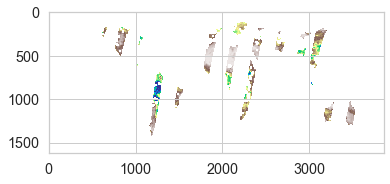

In [10]:
plt.imshow(sm_data,vmin=0.,vmax=0.55,cmap='terrain_r')

### Let's work with one file

### Co-locate to a single landslide event

(1624, 3856)
40.456059296482785 40.4802
-106.85165975103735 -106.8393


Text(0.5, 1.0, 'SMAP Soil Moisture')

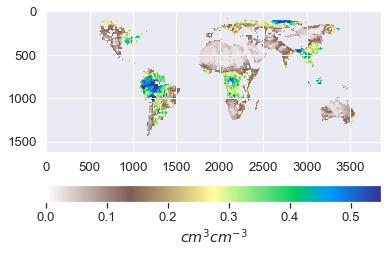

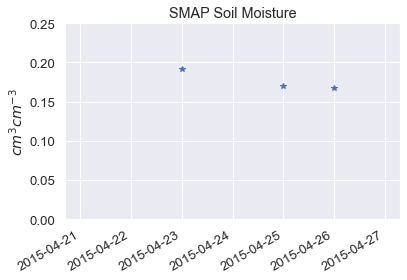

In [56]:
periods = 7
glc_date = pd.date_range(glc_co_gt2015.index[0], periods=periods,
                         freq='-1D').strftime('%Y%m%d')

# Loop over the X days and create list of DataArrays
sm_dates = []
sm_data_3d = np.empty([sm_data.shape[0], sm_data.shape[1], periods])

i = 0
for dd in glc_date:
    # Find the file
    file = [x for x in smap_files if re.findall(dd, x)]

    # Retrieve the variables
    sm_data_3d[:, :, i], time_i = read_smap(file[0], 24)
    sm_dates.append(time_i)
    i += 1

sm_mean = np.nanmean(sm_data_3d,2)
print(sm_mean.shape)

plt.imshow(sm_mean,vmin=0.,vmax=0.55,cmap='terrain_r')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

# take the +/- 0.5 deg mean around the Landslide event
N_lat = glc_co_gt2015.latitude[0]+0.15
S_lat = glc_co_gt2015.latitude[0]-0.15
W_lon = glc_co_gt2015.longitude[0]-0.15
E_lon = glc_co_gt2015.longitude[0]+0.15

subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
sm_mean = np.empty([periods])
for i in np.arange(0, sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:, :, i]
    sm_mean[i] = np.nanmean(sm_2d[subset])

print(np.nanmean(lats[subset]), glc_co_gt2015.latitude[0])
print(np.nanmean(lons[subset]), glc_co_gt2015.longitude[0])

# Lets create a pandas series to plot the data
smData = {'sm': sm_mean}
sm = pd.DataFrame(smData)
sm['sm_date'] = sm_dates
sm = sm.set_index('sm_date')
sm['landslide_id'] = glc_co_gt2015.event_id[0]

# plot the time series
fig, ax1 = plt.subplots()
ax1.plot(sm.index, sm, 'b*')
ax1.set_ylim([0, 0.25])
fig.autofmt_xdate()
ax1.set_ylabel('$cm^3 cm^{-3}$')
plt.title('SMAP Soil Moisture')

#### Read a second time period to learn about appending 

In [ ]:
periods = 7
glc_date = pd.date_range(glc_co_gt2015.index[1], periods=periods,
                         freq='-1D').strftime('%Y%m%d')

# Loop over the X days and create list of DataArrays
sm_dates = []
sm_data_3d = np.empty([sm_data.shape[0], sm_data.shape[1], periods])

i = 0
for dd in glc_date:
    # Find the file
    file = [x for x in smap_files if re.findall(dd, x)]

    # Retrieve the variables
    sm_data_3d[:, :, i], time_i = read_smap(file[0], 24)
    sm_dates.append(time_i)
    i += 1

# take the +/- .5 deg mean around the Landslide event
N_lat = glc_co_gt2015.latitude[1]+0.25
S_lat = glc_co_gt2015.latitude[1]-0.25
W_lon = glc_co_gt2015.longitude[1]-0.25
E_lon = glc_co_gt2015.longitude[1]+0.25

subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
sm_mean = np.empty([periods])
for i in np.arange(0, sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:, :, i]
    sm_mean[i] = np.nanmean(sm_2d[subset])

# Lets create a pandas series to plot the data
smData = {'sm': sm_mean}
sm2 = pd.DataFrame(smData)
sm2['sm_date'] = sm_dates
sm2 = sm2.set_index('sm_date')
sm2['landslideID'] = glc_co_gt2015.event_id[1]

In [ ]:
res = pd.DataFrame()
res = res.append(sm)
res = res.append(sm2)
res2 = res.groupby('landslideID').agg({'sm': ['mean', 'min', 'max', 'median']})
res2.columns = res2.columns.map('_'.join)
res2

### Now let us do this for the entire Landslide time series

In [62]:
# Assign the first dataFrame. This is because we don't have all the dates for 2015.
# soilm_df = sm
sm_date = []
landslide_id = []
landslide_cat = []
landslide_trig = []
landslide_sz = []
lat = []
lon = []
periods = 7
count_down = []
sm_mean = []
sfct_mean = []
vegop_mean = []
vegwc_mean = []

for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):
    
    # Loop over -7 days from the event
    glc_date = pd.date_range(ls_date, periods=periods,
                         freq='-1D').strftime('%Y%m%d')
    
    countd = periods
    
    # Take the +/- 0.3 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.15
    S_lat = glc_co_gt2015.latitude[i]-0.15
    W_lon = glc_co_gt2015.longitude[i]-0.15
    E_lon = glc_co_gt2015.longitude[i]+0.15
       
    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
    
    for dd in glc_date:
        # Find the SMAP file
        file = [x for x in smap_files if re.findall(dd, x)]
        
        # Retrieve the variables
        sm, time_t = read_smap(file[0], 24)
        #sfct, t = read_smap(file[0], 31)
        vegop, t = read_smap(file[0], 46)
        vegwc, t = read_smap(file[0], 50)
        
        sm_mean.append(np.nanmean(sm[subset]))
        #sfct_mean.append(np.nanmean(sfct[subset]))
        vegop_mean.append(np.nanmean(vegop[subset]))
        vegwc_mean.append(np.nanmean(vegwc[subset]))
        
        sm_date.append(time_t)
        
        # Append landslide metadata
        lat.append(glc_co_gt2015.latitude[i])
        lon.append(glc_co_gt2015.longitude[i])

        landslide_id.append(glc_co_gt2015.event_id[i])
        landslide_cat.append(glc_co_gt2015.landslide_category[i])
        landslide_trig.append(glc_co_gt2015.landslide_trigger[i])
        landslide_sz.append(glc_co_gt2015.landslide_size[i])
    
        # Append countdown
        count_down.append(countd)
        countd -=1

# Create a pandas series
soilm_df = pd.DataFrame(sm_mean, 
                      index= pd.to_datetime(sm_date), columns=['smap_sm'])
soilm_df['veg_opacity'] = vegop_mean
soilm_df['veg_water_content'] = vegwc_mean
#soilm_df['surface_temperature'] = sfct_mean
#soilm_df['surface_temperature'] = soilm_df['surface_temperature'] - 273.15
soilm_df['glc_lat'] = lat
soilm_df['glc_lon'] = lon
soilm_df['landslide_id'] = landslide_id
soilm_df['landslide_category'] = landslide_cat
soilm_df['landslide_trigger'] = landslide_trig
soilm_df['landslide_size'] = landslide_sz
soilm_df['days-to-landslide'] = count_down


In [63]:
soilm_df

,smap_sm,veg_opacity,veg_water_content,glc_lat,glc_lon,landslide_id,landslide_category,landslide_trigger,landslide_size,days-to-landslide
2015-05-11,NaN,NaN,NaN,40.480200,-106.839300,6994,landslide,continuous_rain,medium,7
2015-05-10,NaN,NaN,4.308795,40.480200,-106.839300,6994,landslide,continuous_rain,medium,6
2015-05-09,NaN,NaN,NaN,40.480200,-106.839300,6994,landslide,continuous_rain,medium,5
2015-05-08,0.237144,0.240331,2.819524,40.480200,-106.839300,6994,landslide,continuous_rain,medium,4
2015-05-07,0.275654,0.327607,4.257044,40.480200,-106.839300,6994,landslide,continuous_rain,medium,3
...,...,...,...,...,...,...,...,...,...,...
2020-07-25,NaN,NaN,NaN,39.567403,-107.272192,1111,mudslide,downpour,large,5
2020-07-24,0.181287,0.282841,3.320279,39.567403,-107.272192,1111,mudslide,downpour,large,4
2020-07-23,0.255919,0.297100,3.328619,39.567403,-107.272192,1111,mudslide,downpour,large,3
2020-07-22,NaN,NaN,NaN,39.567403,-107.272192,1111,mudslide,downpour,large,2


### Plot time series

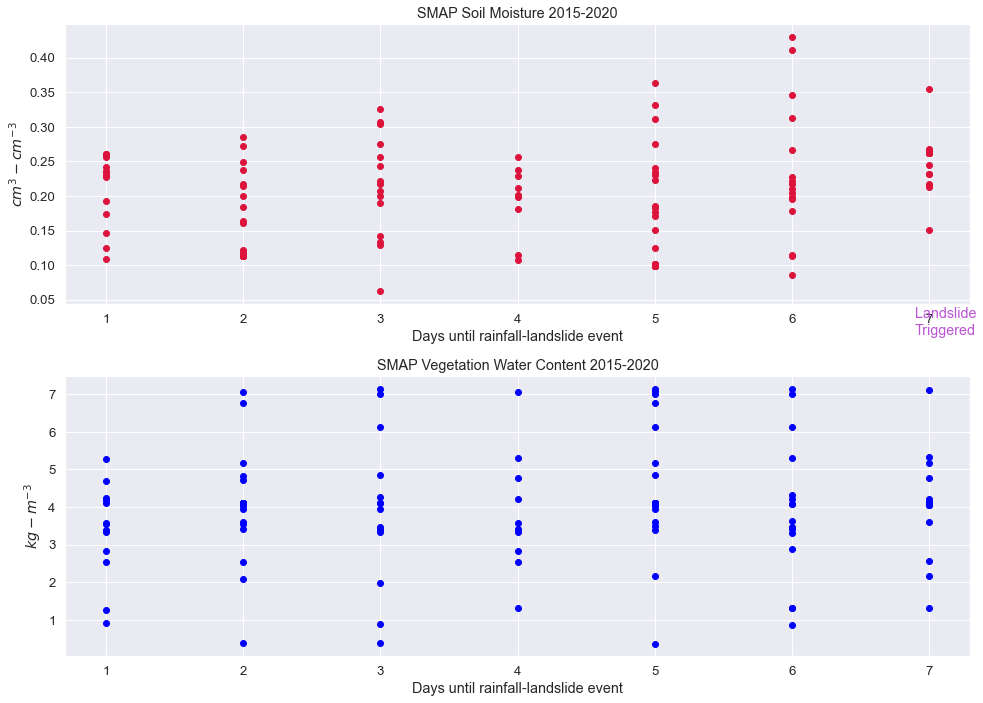

In [65]:
sns.set(font_scale=1.2)
#sns.set(font_scale=1.2, style="whitegrid")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

for id, df in soilm_df.groupby("landslide_id"):
    ax1.plot(df['days-to-landslide'], df['smap_sm'],
            marker='o', linestyle='none', color='crimson')

ax1.set(xlabel='Days until rainfall-landslide event',
       ylabel='$cm^3 - cm^{-3}$',
       title='SMAP Soil Moisture 2015-2020')

ax1.text(6.9, 0.0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

for id, df in soilm_df.groupby("landslide_id"):
    ax2.plot(df['days-to-landslide'], df['veg_water_content'],
            marker='o', linestyle='none', color='blue')

ax2.set(xlabel='Days until rainfall-landslide event',
       ylabel='$kg-m^{-3}$',
       title='SMAP Vegetation Water Content 2015-2020')



plt.tight_layout()
#plt.savefig(os.path.join(et.io.HOME,
#             'earth-analytics',
#             'ea-python-2022-capstone', 'plots',
#             'smap_soilmoisture_timeseries.png'))

#### Get statistics

In [20]:
soilm_df.shape

(266, 9)

In [23]:
soilm_stats_df = soilm_df.groupby('landslide_id').agg(
                                    {'smap_sm': ['mean', 'min', 'max', 'median']})
soilm_stats_df.columns = soilm_stats_df.columns.map('_'.join)
soilm_stats_df

,smap_sm_mean,smap_sm_min,smap_sm_max,smap_sm_median
landslide_id,,,,
1111,0.124297,0.106196,0.146050,0.122472
6940,0.131784,0.103479,0.157643,0.143766
6994,0.194476,0.189701,0.197138,0.196588
7047,0.225176,0.198325,0.252027,0.225176
7048,0.194587,0.185991,0.205228,0.192541
7051,0.198036,0.160486,0.238028,0.195594
7052,0.190452,0.155470,0.248197,0.179069
7053,0.192017,0.155470,0.248197,0.172383
7060,0.232122,0.190735,0.301944,0.203687
